In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mpl_toolkits import mplot3d

import plotly.express as px

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import correlation, cosine
from scipy.stats import describe
from scipy.sparse.linalg import svds

# Method to get Principal Components.

In [2]:
def get_pca(data,n):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(data)
    principalComponents = pd.DataFrame(data = principalComponents)
    return(pca,principalComponents)

## Method to plot Pareto of the Principal Components.

In [3]:
def plot_pareto(pca, principalComponents):
    
    plt.bar(principalComponents.columns,pca.explained_variance_ratio_)
    df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                       'PC':principalComponents.columns})
    df["cummulative"] = df["var"].cumsum()/df["var"].sum()*100
    
    fig, ax = plt.subplots()
    ax.bar(df['PC'], df["var"])
    ax.set_ylabel('Variance')
    ax.set_xlabel('Principal Components')
    ax2 = ax.twinx()
    ax2.plot(df['PC'], df["cummulative"], color="C1")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.axvline(x=150, label='line at x = {}'.format(150),c='red')
    ax2.hlines(y=80, xmin=0, xmax=240, linestyles='dashed')
    ax2.set_title('Pareto Plot')


    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
#     plt.savefig('Pareto.png', dpi = 300)
    plt.show()
#     plt.savefig('Pareto.png')

### - Importing the Useritem Matrix, meta data and ratings dataframe. ##
### - Replacing NA values with 0. ##
### - Applying PCA for dimension reduction. ##

In [4]:
# Importing the Useritem Matrix.
useritem = pd.read_csv('C:/Semester 2/USML/Project_Final/AMAZON_FASHION_user_itemset.csv',index_col=0)
meta_data = pd.read_json('C:/Semester 2/USML/Project_Final/meta_AMAZON_FASHION.json',lines=True)
ratings_df = pd.read_json('C:/Semester 2/USML/Project_Final/AMAZON_FASHION.json',lines=True)

data = useritem.fillna(0)

# Applying PCA for dimension reduction.
pca , principalComponents = get_pca(data,None)

### - Plotting pareto to visualise the principal components.

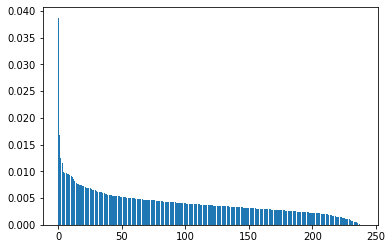

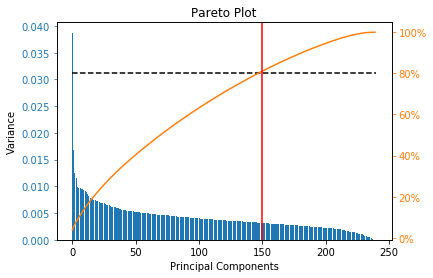

In [5]:
plot_pareto(pca, principalComponents)

#### As we can see 150 principal components contain more than 80% of the data.

#### We will consider only the top 150 components for further clustering similar user groups.


In [6]:
pca , principalComponents = get_pca(data,150)

## Plotting the Dendrogram with cosine distance and single linkage.

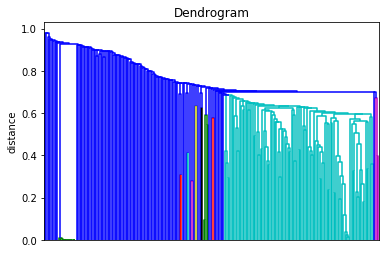

In [7]:
plt.title('Dendrogram')
plt.ylabel('distance')
dendogram = sch.dendrogram(sch.linkage(principalComponents,method='single', metric="cosine"),no_labels=True,)
plt.show
plt.savefig('dendrogram_single.png', dpi = 300)

**We can see that single linkage does not cluster properly henct we try different linkages.**

## Plotting the Dendrogram with cosine distance and average linkage.

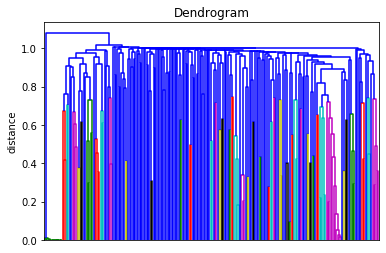

In [8]:
plt.title('Dendrogram')
plt.ylabel('distance')
dendogram = sch.dendrogram(sch.linkage(principalComponents,method='average', metric="cosine"),no_labels=True,)
plt.show
plt.savefig('dendrogram_average.png', dpi = 300)

## Plotting the Dendrogram with cosine distance and complete linkage.

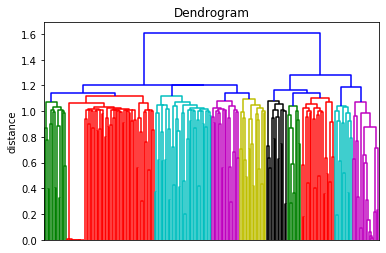

In [9]:
plt.title('Dendrogram')
plt.ylabel('distance')
dendogram = sch.dendrogram(sch.linkage(principalComponents,method='complete', metric="cosine"),no_labels=True,)
plt.show
plt.savefig('dendrogram_complete.png', dpi = 300)

**From the dendrogram we can see that cosine distanc with Complete linkage gives the best results.**

**We can see that 8 looks like a good value for n_clusters.**

**We now run Agglomerative Clustering and cluster similar users.**

In [10]:
aggclust = AgglomerativeClustering(8, affinity='cosine', linkage='complete')
hc = aggclust.fit_predict(principalComponents)

**To make sure our clusters have adequate data points let us count the number of datapoints in each cluster.**

In [11]:
unique_elements, counts_elements = np.unique(hc, return_counts=True)
print("Frequency of unique values in each cluster:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values in each cluster:
[[ 0  1  2  3  4  5  6  7]
 [34 79 15 19 41 13 19 20]]


**We can now group similar users in different dataframes.**

In [12]:
data['labels'] = hc
groups = [x for _, x in data.groupby(data['labels'])]

#in each group remove columns of items which none of the customers from that group bought.
for i in range(len(groups)):
    groups[i] = groups[i].loc[:, (groups[i] != 0.0).any(axis=0)]
    groups[i] = groups[i].loc[:, groups[i].columns != 'labels']

## We now apply matrix factorisation on the similar users groups to get the best factors representing the users and items.

### By doing this we get the U, sigma, and V matrices with K = 5 features.
**- The U matrix represents the users and the columns of each user represents how much the user favors each of those features.**

**- The V transpose matrix represents the item and the columns of each item represents how much of the features are present in each item.**

**- The sigma matrix contains the weights of each feature.**

## Method to perform Matrix factorisation.

In [13]:
def matrix_factorisation(R_demeaned,k):
    U, sigma, Vt = svds(R_demeaned, k = k)
    sigma = np.diag(sigma)
    
    return(U, sigma, Vt)

### To make predictions of the ratings that a user u might give for an item i, where item i has not been bought by user u before. We find the product of the feature vector of that user with sigma and with the feature vector of the item from V.

### We do this and predict all ratings ratings for all the items that each user might have given. 

In [14]:
def make_predictions(R_df,k):
    R = R_df.values
    R_mean = np.mean(R, axis = 1)
    R_demeaned = R - R_mean.reshape(-1, 1)
    
    U, sigma, Vt = matrix_factorisation(R_demeaned,k)
    
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + R_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns, index = R_df.index)
    
    return(preds_df)

### To make recommendations for a user, we use the original user-item matrix to determine and remove which products the user has already purchased. we then arrange the predicted ratings in descending order and the top N ratings are taken.

### Using the metadata of the top N products, product details are retrieved. The product details are then recommended to the customer.

In [15]:
def recommend_items(df, userID, meta_data, ratings_df, num_recommendations=1):
    
    # Get predicted matrix
    preds_df = make_predictions(df,5)
    
    # Get and sort the user's predictions
    sorted_user_predictions = preds_df.loc[userID , :].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the item information.
    user_data = ratings_df[ratings_df.reviewerID == userID]
    user_full = (user_data.merge(meta_data, how = 'left', left_on = 'asin', right_on = 'asin').
                     sort_values(['overall'], ascending=False))
    
    # Recommend the highest predicted rating items that the user hasn't purchased yet.
    recommendations = (meta_data[~meta_data['asin'].isin(user_full['asin'])].
         merge(pd.DataFrame(sorted_user_predictions), how = 'left',
               left_on = 'asin',
               right_index=True).
         rename(columns = {userID: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return recommendations

# The following code to recommend items using matrix factorisation was reffered from 
# https://beckernick.github.io/matrix-factorization-recommender/

In [16]:
predictions = recommend_items(groups[0], 'A1I98GJAHJHSAM', meta_data, ratings_df, 4)
predictions

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
66743,Antique Brass Tone Tribal Jewelry Shield Fring...,[https://images-na.ssl-images-amazon.com/image...,NaN,[Package Dimensions:\n \n5 ...,"892,242inClothing,ShoesJewelry(",No,B00PJIPZGW,NaN,NaN,NaN,"[B00MIMQIJU, B00KA3VX62, B00KW02LNC, B07K52TXC9]",NaN,NaN,NaN,NaN
100389,Born Pretty Dreamcatcher Earrings Alloy Feathe...,[https://images-na.ssl-images-amazon.com/image...,NaN,[Product Dimensions:\n \n4....,"1,225,610inClothing,ShoesJewelry(",5 star,B010SGA0CI,NaN,$2.85,NaN,[B01LXCTUSB],NaN,NaN,NaN,NaN
28559,Yazilind Black Lace Slave Bracelets Ring Lolit...,[https://images-na.ssl-images-amazon.com/image...,NaN,[Package Dimensions:\n \n3....,"1,387,853inClothing,ShoesJewelry(",No,B00ELZPJ24,NaN,NaN,NaN,"[B010NHL7NS, B00TAH56N0]",NaN,NaN,NaN,NaN
22587,Round Beads Red Turquoise VTG Tibet Silver Lin...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"1,234,958inClothing,ShoesJewelry(",B2669K,B00C0ORAV6,NaN,NaN,NaN,"[B00KREP1HQ, B07BXWWT4R, B076Z7DGL3, B00MVU2VF...",NaN,NaN,NaN,NaN


## Calculating the Performance of the recommender system.

### We do the following steps to calculate the performance of the recommender system :-

**- Take the original data and perform matrix factorization to get the best factors.**

**- Use these factors to make predictions for the approximate ratings which all the users might have given for each item.**

**- Use the Predicted matrix and remove all the missing values from the original user item matrix.**

**- Compare and calculate mean absolute error between the new matrix generated and the original user item matrix.**

In [17]:
#creating preds df for a user item matrix. Lets take groups[0] for example
preds_df = make_predictions(groups[0],5)

#Making predictions only for purchased items
pre=np.where(groups[0] == 0, 0, preds_df) 

#Comparing predictions with original data
mean_absolute_error(pre, groups[0])

0.09619160381017551